# Project 4 Causal Inference Report
## Group 3

## 1 Project Overview

Propensity scores addresses selection bias from observational data.

## 2 Data Preparation
### 2.1 Load Required Packages

"Y" indicates the outcome variable, "A" is the treatment group assignment, and there are 22 covariates.

In [4]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# setting graph styles
sns.set(rc={'figure.figsize':(10,8)})
#sns.set_theme(style='ticks') broken

# set seed
random_state = 2021

### 2.2 Load Data

In [8]:
# load high dimensional data
highdim_data = pd.read_csv('../data/highDim_dataset.csv')

# load low dimensional data
lowdim_data = pd.read_csv('../data/lowDim_dataset.csv')


In [9]:
print("The high dimensional data has",highdim_data.shape[0],"observations and", highdim_data.shape[1], "variables.")
print("The low dimensional data has",lowdim_data.shape[0],"observations and", lowdim_data.shape[1], "variables.")
      

The high dimensional data has 2000 observations and 187 variables.
The low dimensional data has 500 observations and 24 variables.


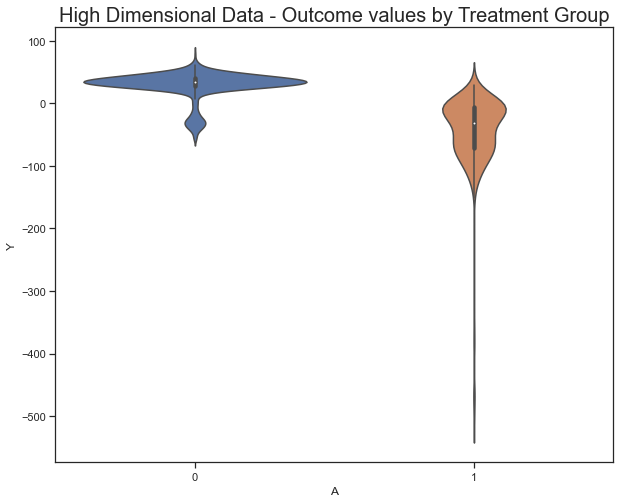

In [4]:
# visualize outcome values on high dimensional data by treatment group
sns.violinplot(x="A", y="Y", data=highdim_data)
plt.title('High Dimensional Data - Outcome values by Treatment Group', size=20)
plt.show()

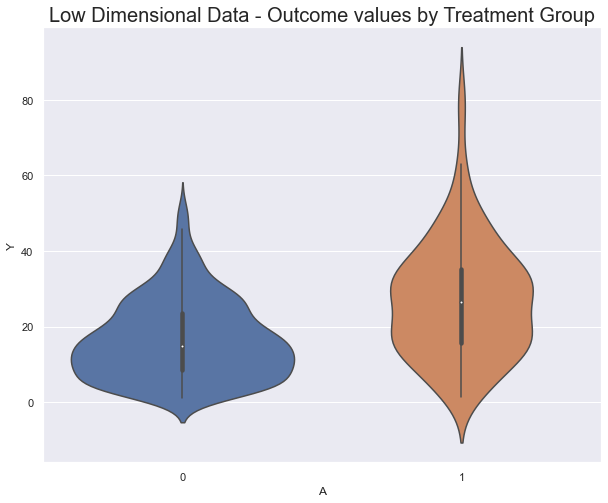

In [10]:
# visualize outcome values on low dimensional data by treatment group
sns.violinplot(x="A", y="Y", data=lowdim_data)
plt.title('Low Dimensional Data - Outcome values by Treatment Group', size=20)
plt.show()

## 3 Propensity Scores Estimation and Evaluation
We will use L1 penalized logistic regression to estimate propensity scores for both data sets.

### 3.1 Create Propensity Score Estimation Functions

In [11]:
# create a function to tune for best hyperparameters for each data set

def best_param(data, random_state, param_grid, cv=10):
    '''
    Purpose: to find the best parameter "C" (coefficient of regularization strength) for the specific dataset
    
    Parameters:
    data - dataset to best tested on 
    random_state - set seed
    param_grid - set of parameter values to test on
    cv - number of folds for cross-validation
    
    '''

    x = data.drop(['A','Y'], axis = 1)  
    y = data[['A']].values.ravel()
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_state)
    
    
    model_cv = GridSearchCV(LogisticRegression(penalty='l1',solver = 'liblinear'), param_grid, cv=cv)
    model_cv.fit(x_train, y_train)
    
    print("The best tuned coefficient of regularization strength is",model_cv.best_params_.get('C'), 
          "with a testing accuracy of", model_cv.score(x_test, y_test))
    
    return model_cv.best_params_.get('C')


In [18]:
def propensity_score(data, C=0.1, plot = True):
    '''
    Purpose: to estimate propensity score with L1 penalized logistic regression
    
    Parameters:
    data - dataset to estimate on 
    C - coeficient of regularization strength
    plot - print out visualization to show distribution of propensity scores
    
    Returns:
    1. ps for Propensity Score
    2. Visualization plot to show distribution of propensity scores
    
    '''
    
    T = 'A'
    Y = 'Y'
    X = data.columns.drop([T,Y])
    
    ps_model = LogisticRegression(random_state=random_state, penalty='l1',
                                  solver='liblinear').fit(data[X], data[T]) 
    
    ps = ps_model.predict_proba(data[X])[:,1] # we are interested in the probability of getting a "1"
    
    if plot:
        df_plot = pd.DataFrame({'Treatment':data[T], 'Propensity Score':ps})
        
        sns.histplot(data=df_plot, x = "Propensity Score", hue = "Treatment", element = "step")
        plt.title("Distribution of Propensity Score by Treatment Group", size=20)
        plt.show()
   
    return ps


In [12]:
# setting parameters
param_grid = {"C":[0.01,0.05,0.1,0.3,0.5,0.7,1]}

### 3.2 Evaluate Propensity Scores for High Dimensional Data

In [13]:
# use 10-fold cross-validation to tune for the best parameter for logistic regression
c_high = best_param(highdim_data, random_state=random_state, param_grid=param_grid)

The best tuned coefficient of regularization strength is 0.01 with a testing accuracy of 0.71


In [19]:
# estimate propsensity scores
ps_high = propensity_score(highdim_data, C = c_high)

AttributeError: module 'seaborn' has no attribute 'histplot'

### 3.3 Evaluate Propensity Scores for Low Dimensional Data

In [14]:
# use 10-fold cross-validation to tune for the best parameter for logistic regression
c_low = best_param(lowdim_data, random_state=random_state, param_grid=param_grid)

The best tuned coefficient of regularization strength is 0.3 with a testing accuracy of 0.8


In [15]:
ps_low = propensity_score(lowdim_data, C = c_low)

NameError: name 'propensity_score' is not defined

## 4 Algorithm Functions and Evaluation

In [17]:
## Stratification

def stratification(data, prop):
    start = time.time()
    K = 5 # k, quintiles is reccomended
   # N = len(df.index)
    strata = [1,2,3,4,5]
    ATE = 0

    #split propensity scores into thier respective quintiles 
    prop_split = pd.qcut(prop, K)
    prop_split.categories = strata 
    
    
    #label the dataset and group accordingly
    quintiles = copy.copy(data)
    quintiles["strata"] = prop_split
    quintiles = quintiles[["A", "strata", "Y"]]

    #calucate the average Y
    quintiles = quintiles.groupby(["A", "strata"]).mean

    for num in strata:
        ATE += quintiles.loc[pd.IndexSlice[(1, num)] - quintiles.loc[pd.IndexSlice[(0, num)] 
    
    #Divide by N
    ATE = ATE/K

    end = time.time()

    print("Estamated ATE: ", round(ATE.values[0], 2))
    print("Runtime: ", end-start)

    return(ATE, end-start)
    


## 5 Conclusion